# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

## Importing Dataset and Data Munging

In [1112]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
## Load the data into a DataFrame
df = pd.read_csv('../Resources/Iowa_Liquor_sales_sample_10pct.csv')

### Filling in missing values in County Names as well as misspelled city names

In [1113]:
#fixing missing county names
cc = df.set_index('City')['County'].to_frame()
cc.dropna(inplace=True)
undefined = pd.DataFrame([['Wayne'],['Polk'],['Fremont']], columns=['County'], index=['SEYMOUR', 'RUNNELLS', 'TABOR'])
df2 = pd.concat([cc, undefined])

def get_county(city):
    return df2.T[city].values[0][0]


In [1114]:
citys_wo_county = df[pd.isnull(df["County"])]["City"].to_frame()
for row in citys_wo_county.index:
    df.set_value(row, 'County', get_county(citys_wo_county.ix[row]['City']))

In [1115]:
#fixing spelling errors
df['City'] = df['City'].apply(lambda x: x.replace('MOUNT PLEASANT','MT PLEASANT'))
df['City'] = df['City'].apply(lambda x: x.replace('OTTUWMA','OTTUMWA'))
df['City'] = df['City'].apply(lambda x: x.replace('MOUNT VERNON','MT VERNON'))
df['City'] = df['City'].apply(lambda x: x.replace('ARNOLDS PARK','ARNOLD\'S PARK'))
df['City'] = df['City'].apply(lambda x: x.replace('LEMARS','LE MARS'))
df['City'] = df['City'].apply(lambda x: x.replace('LECLAIRE','LE CLAIRE'))
df['City'] = df['City'].apply(lambda x: x.replace('DEWITT','DE WITT'))
df['City'] = df['City'].apply(lambda x: x.replace('GUTTENBURG','GUTTENBERG'))
df['City'] = df['City'].apply(lambda x: x.replace('JEWELL','JEWELL JUNCTION'))
df['City'] = df['City'].apply(lambda x: x.replace('JEWELL JUNCTION JUNCTION','JEWELL JUNCTION'))
df['City'] = df['City'].apply(lambda x: x.replace('KELLOG','KELLOGG'))
df['City'] = df['City'].apply(lambda x: x.replace('KELLOGGG','KELLOGG'))


In [1119]:
df[(df['County']=='W') | (df['County']=='P') | (df['County']=='F')]

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)


In [1118]:
#setting individual values to correct County
df.ix[46599,'County'] = 'Fremont'
df.ix[50149,'County'] = 'Wayne'
df.ix[89794,'County'] = 'Wayne'
df.ix[120722,'County'] = 'Wayne'
df.ix[131595,'County'] = 'Wayne'
df.ix[140719,'County'] = 'Fremont'
df.ix[156543,'County'] = 'Polk'
df.ix[168748,'County'] = 'Wayne'
df.ix[202083,'County'] = 'Fremont'
df.ix[213206,'County'] = 'Fremont'
df.ix[234840,'County'] = 'Polk'
df.ix[259771,'County'] = 'Wayne'

### Filling in missing values in Category Names

In [1120]:
#fixing missing categories
cat = df.set_index('Category')['Category Name'].to_frame()
cat.dropna(inplace=True)
undefined_cats = pd.DataFrame([["Moonshine"],["Reposado"],["Vodka"],["Hennessy"],["Spiced Rum"],["Rum"],["Amaretto"],["Spirit"],["Moonshine"],["Moonshine"],["Rum"]], columns=['Category Name'], index=['1011700.0', '1022200.0', '1032100.0', '1052100.0', '1062400.0', '1062500.0', '1082100.0', '1082200.0', '1091100.0', '1091300.0', '1092100.0'])
all_cats = pd.concat([cat, undefined_cats])

def get_category_name(category):
    return all_cats.T[str(float(category))].values[0]

In [1121]:
category_wo_name = df[pd.isnull(df["Category Name"])]["Category"].to_frame()

for row in category_wo_name.index:
    if not np.isnan(category_wo_name.ix[row]['Category']):
        df.set_value(row, 'Category Name', get_category_name(category_wo_name.ix[row]['Category']))

In [1122]:
del df['County Number']
print df.shape

(270955, 17)


#### Converting Date field to datetime object

In [1123]:
#converting to datetime
df["Date"] = pd.to_datetime(df["Date"])

In [1124]:
del df['Category']

In [1125]:
#removing $ and converting to float
df['State Bottle Cost'] = df['State Bottle Cost'].apply(lambda x: str(x).replace('$','')).astype(float)
df['State Bottle Retail'] = df['State Bottle Retail'].apply(lambda x: str(x).replace('$','')).astype(float)
df['Sale (Dollars)'] = df['Sale (Dollars)'].apply(lambda x: str(x).replace('$','')).astype(float)
df['City'] = df['City'].apply(lambda x: x.upper())

#### Constrain the dataframe to 2015

In [1128]:
#only using the 2015 year data
df = df[df['Date'].dt.year == 2015]

### Creating Train/Test Split

In [1129]:
df_y = df['Sale (Dollars)']
df_X = df.drop(["Sale (Dollars)"], axis=1)

In [820]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.33)

#### Concatenating X_train and Y_train for Analysis

In [1130]:
#creating total cost column
tot_cost = df['Bottles Sold']*df['State Bottle Cost']
insert_totcost = df.columns.get_loc('Sale (Dollars)') + 1
df.insert(insert_totcost,'Total_Cost',tot_cost)

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [1131]:
df.head()

,Date,Store Number,City,Zip Code,County,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,Bremer,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,4.50,6.75,12,81.00,54.00,9.00,2.38
4,2015-08-18,3654,BELMOND,50421,Wright,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,7.20,10.80,12,129.60,86.40,21.00,5.55
5,2015-04-20,2569,CEDAR RAPIDS,52402,Linn,AMERICAN DRY GINS,205,31473,New Amsterdam Gin,1750,13.32,19.98,6,119.88,79.92,10.50,2.77
6,2015-08-05,2596,OTTUMWA,52501,Wapello,AMERICAN GRAPE BRANDIES,85,52806,Korbel Brandy,750,6.66,9.99,3,29.97,19.98,2.25,0.59
7,2015-06-25,3456,CLEAR LAKE,50428,Cerro Gordo,CANADIAN WHISKIES,65,10628,Canadian Club Whisky,1750,15.75,23.63,2,47.26,31.50,3.50,0.92


In [1132]:
df.describe()

,Store Number,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
count,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000,218594.000000
mean,3578.700216,255.976783,45947.926064,925.621609,9.771547,14.675065,9.950456,130.503332,86.860051,9.087232,2.400800
std,942.194733,141.266301,52563.817681,492.014837,7.021363,10.531652,24.449269,386.612714,256.816527,29.360489,7.756215
min,2106.000000,10.000000,173.000000,50.000000,0.890000,1.340000,1.000000,1.340000,0.890000,0.100000,0.030000
25%,2603.000000,115.000000,26828.000000,750.000000,5.510000,8.270000,2.000000,30.720000,20.430000,1.600000,0.420000
50%,3715.000000,260.000000,38176.000000,750.000000,8.000000,12.300000,6.000000,70.560000,47.040000,5.250000,1.390000
75%,4349.000000,380.000000,64573.000000,1000.000000,11.920000,17.880000,12.000000,135.660000,90.420000,10.500000,2.770000
max,9018.000000,978.000000,995507.000000,6000.000000,425.000000,637.500000,2508.000000,36392.400000,24261.600000,2508.000000,662.540000


Bottles Sold, Sale (Dollars) are skewed, where the mean minus std is negative. Plotting Histiograms show that we need to restrict to Bottles Sold 25 and less

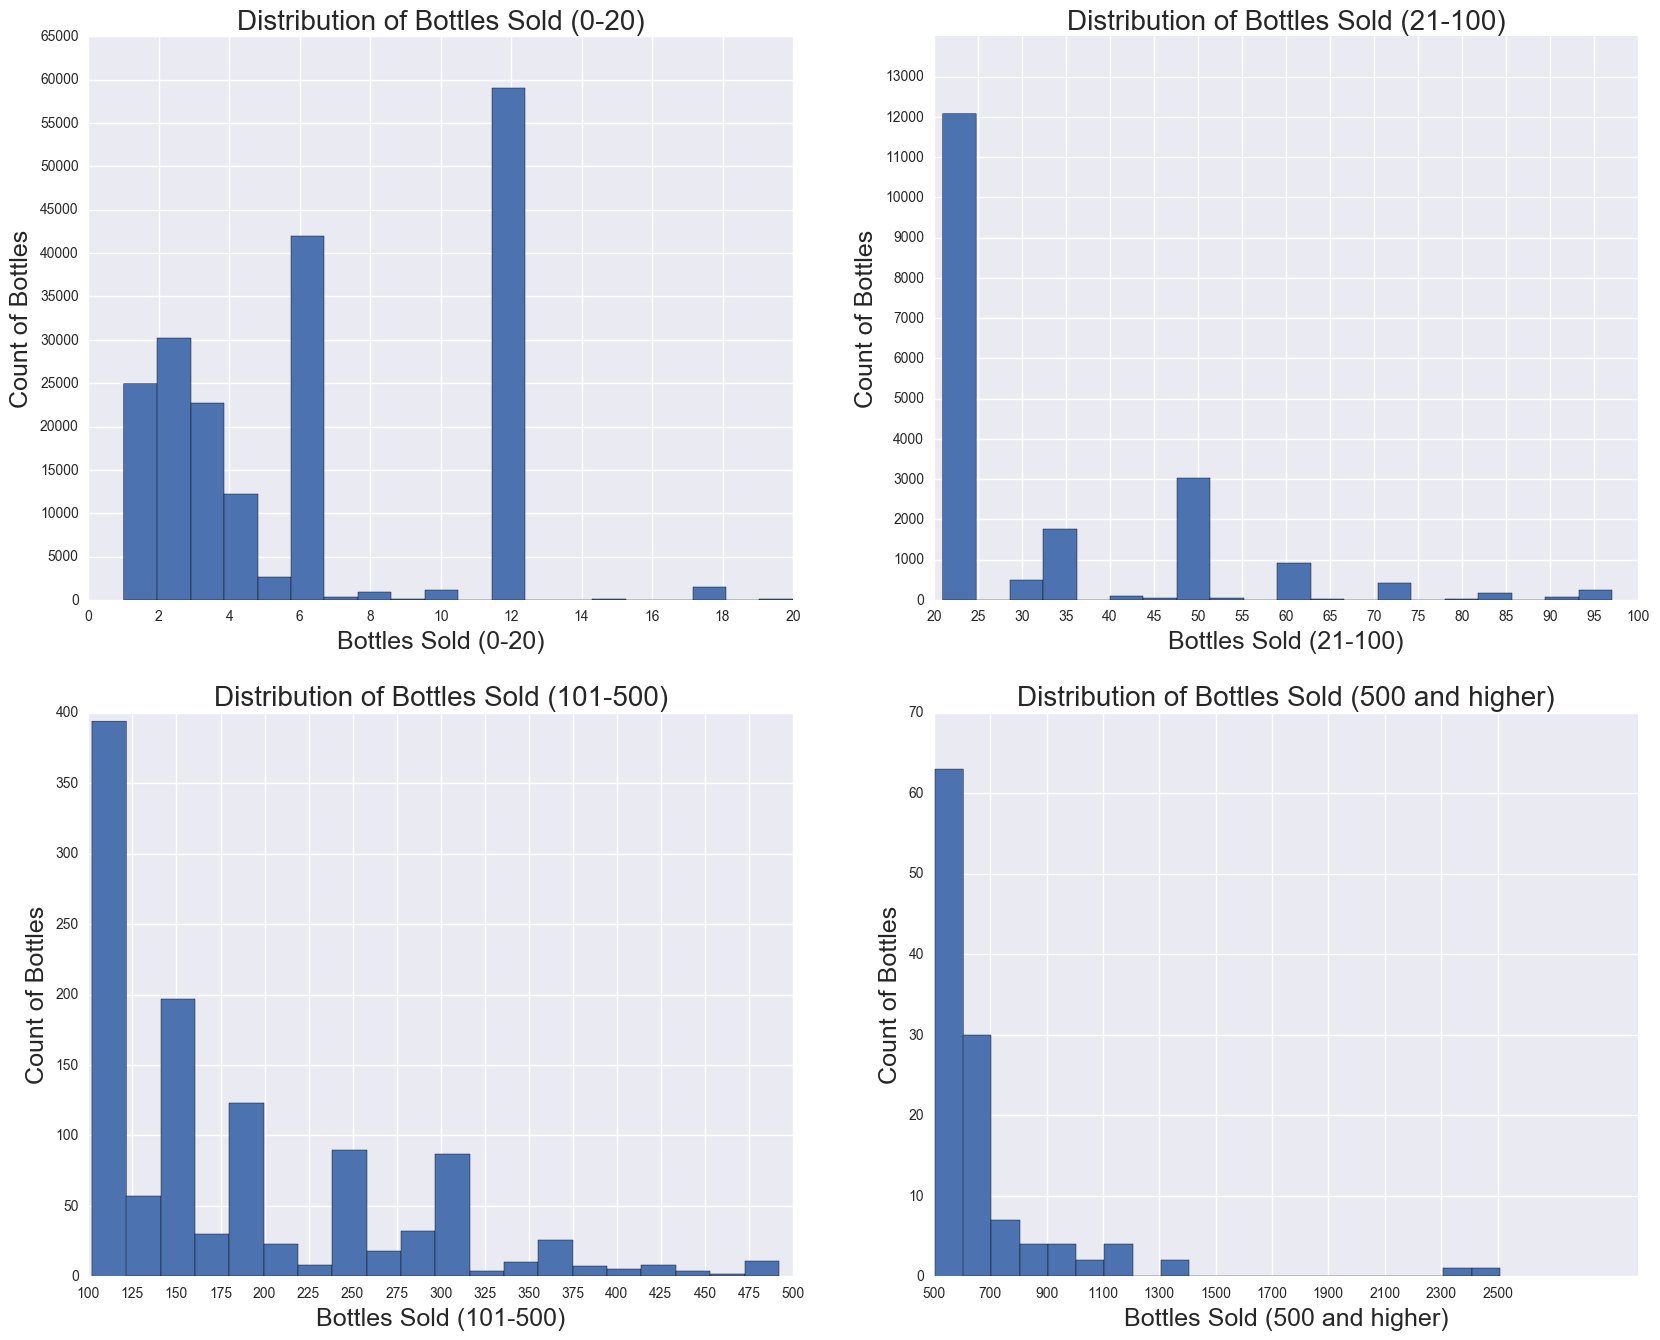

In [1133]:
#evaluating bottles sold
fig, axes = plt.subplots(2,2, figsize=(20,16))
#Bottles Sold less than or equal to 10
axes[0][0].hist(x = df[df['Bottles Sold']<=20]['Bottles Sold'],bins = 20) 
axes[0][0].xaxis.set_ticks(np.arange(0, 21, 2))
axes[0][0].yaxis.set_ticks(np.arange(0, 70000, 5000))
axes[0][0].set_title('Distribution of Bottles Sold (0-20)',fontsize = 20)
axes[0][0].set_xlabel('Bottles Sold (0-20)',fontsize = 18)
axes[0][0].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 10 and less than or equal to 100
axes[0][1].hist(x = df[(df['Bottles Sold']>20) & (df['Bottles Sold']<=100)]['Bottles Sold'],bins = 20)
axes[0][1].xaxis.set_ticks(np.arange(20, 101, 5))
axes[0][1].yaxis.set_ticks(np.arange(0, 14000, 1000))
axes[0][1].set_title('Distribution of Bottles Sold (21-100)',fontsize = 20)
axes[0][1].set_xlabel('Bottles Sold (21-100)',fontsize = 18)
axes[0][1].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 100 and less than or equal to 500
axes[1][0].hist(x = df[(df['Bottles Sold']>100) & (df['Bottles Sold']<=500)]['Bottles Sold'],bins=20)
axes[1][0].xaxis.set_ticks(np.arange(100, 501, 25))
axes[1][0].set_title('Distribution of Bottles Sold (101-500)',fontsize = 20)
axes[1][0].set_xlabel('Bottles Sold (101-500)',fontsize = 18)
axes[1][0].set_ylabel('Count of Bottles',fontsize = 18)
#Bottles Sold more than 500 and less than or equal to 2700
axes[1][1].hist(x = df[(df['Bottles Sold']>500) & (df['Bottles Sold']<=2700)]['Bottles Sold'],bins = 20)
axes[1][1].xaxis.set_ticks(np.arange(500, 2700, 200))
axes[1][1].set_title('Distribution of Bottles Sold (500 and higher)',fontsize = 20)
axes[1][1].set_xlabel('Bottles Sold (500 and higher)',fontsize = 18)
axes[1][1].set_ylabel('Count of Bottles',fontsize = 18);

In [1134]:
df[df['Bottles Sold'] < 26].describe()

,Store Number,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
count,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000,209972.000000
mean,3574.938144,256.002700,45987.777961,929.189392,9.843098,14.782341,7.226535,95.188922,63.379533,6.514019,1.721002
std,939.637685,141.524039,51971.895717,489.957932,7.044169,10.565687,5.912067,93.631837,62.388880,5.806351,1.533946
min,2106.000000,10.000000,173.000000,50.000000,0.890000,1.340000,1.000000,1.340000,0.890000,0.100000,0.030000
25%,2603.000000,115.000000,26828.000000,750.000000,5.720000,8.630000,2.000000,29.980000,19.980000,1.500000,0.400000
50%,3713.000000,260.000000,38178.000000,750.000000,8.200000,12.300000,6.000000,67.470000,44.970000,4.500000,1.190000
75%,4345.000000,380.000000,64676.000000,1000.000000,11.960000,17.940000,12.000000,129.120000,86.040000,10.500000,2.770000
max,9013.000000,978.000000,995507.000000,6000.000000,425.000000,637.500000,25.000000,3712.500000,2475.000000,150.000000,39.630000


By creating unique items per store, we can use it as a proxy for store size, which will one of the predictors used in the regression. The histogram for unique per items shows that it is skewed.

(1372, 2)
The mean # of unique items per store is 97.4774052478
The max # of unique items per store is 739
The min # of unique items per store is 1
The median # of unique items per store is 52.0


,Store Number,Unique_Items
0,2106,248
1,2113,94
2,2130,207
3,2152,71
4,2178,184


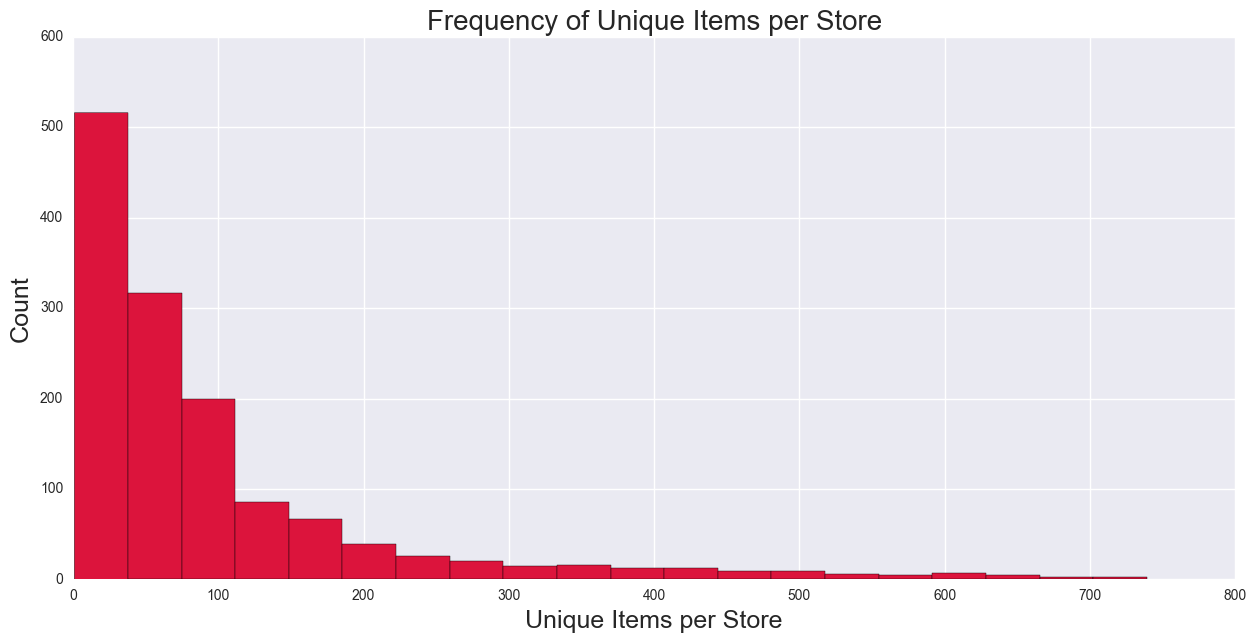

In [1135]:
#creating unique items per store - possible proxy for sq footage given more items per store means a bigger store
#assumption is that that if an item did not sell, the business would remove them from the shelves, each business would maximize revenues
unique_items_per_store = df.groupby('Store Number')['Item Number'].nunique().to_frame('Unique_Items')
unique_items_per_store.reset_index(inplace = True)
unique_items_per_store.sort_values('Unique_Items',ascending = False)
print unique_items_per_store.shape
print "The mean # of unique items per store is", unique_items_per_store['Unique_Items'].mean()
print "The max # of unique items per store is", unique_items_per_store['Unique_Items'].max()
print "The min # of unique items per store is", unique_items_per_store['Unique_Items'].min()
print "The median # of unique items per store is", unique_items_per_store['Unique_Items'].median()

unique_items_per_store['Unique_Items'].hist(bins = 20, figsize = (15,7), color = 'crimson')
plt.title('Frequency of Unique Items per Store',fontsize = 20)
plt.xlabel('Unique Items per Store',fontsize = 18)
plt.ylabel('Count',fontsize = 18)
ax = plt.gca()
unique_items_per_store.head()

In [1136]:
#creating stores per zip/city/county.
stores_per_zip = df.groupby('Zip Code')['Store Number'].nunique().to_frame('Stores_per_zip')
stores_per_zip.reset_index(inplace = True)
stores_per_city = df.groupby('City')['Store Number'].nunique().to_frame('Stores_per_City')
stores_per_city.reset_index(inplace = True)
stores_per_county = df.groupby('County')['Store Number'].nunique().to_frame('Stores_per_County')
stores_per_county.reset_index(inplace = True)

In [1137]:
verify = df[df['Bottles Sold'] < 26].groupby('City')['Bottles Sold'].sum().to_frame()
verify.reset_index(inplace = True)
verify = pd.merge(stores_per_city,verify,how='outer')
verify[verify['Bottles Sold'].isnull()]
df[df['City']=='CUMMING']
#CUMMING is the only city that gets removed when we limit to bottles sold < 26 per transaction
#considering there are only two transactions for CUMMING, we are okay with removing fron the analysis

,Date,Store Number,City,Zip Code,County,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Total_Cost,Volume Sold (Liters),Volume Sold (Gallons)
28118,2015-11-19,9013,CUMMING,50061,Warren,BLENDED WHISKIES,154,27255,Country Gal,750,3.09,4.64,120,556.80,370.80,90.0,23.78
42383,2015-08-04,9013,CUMMING,50061,Warren,BLENDED WHISKIES,154,27255,Country Gal,750,9.17,13.76,12,165.12,110.04,9.0,2.38
100716,2015-12-01,9013,CUMMING,50061,Warren,BLENDED WHISKIES,154,27629,Prairie Fire,750,9.09,13.64,60,818.40,545.40,45.0,11.89
105091,2015-06-04,9013,CUMMING,50061,Warren,VODKA 80 PROOF,154,36447,Ingenioz,750,12.54,18.81,36,677.16,451.44,27.0,7.13


Calculating the Number of Stores per Zip Code, City, and County to be used for number of competitors as a predictor in the regression

Calculating Average Items per Store per City and Sales per Store, which will be used in merges. Histogram shows that there is a skewed distribution.

In [1138]:
#county_store = df.groupby(['County','Store Number'])['Zip Code'].nunique().to_frame('Count')
#county_store.reset_index(inplace = True)
#county_items = pd.merge(county_store,unique_items_per_store,how= 'outer')
#this is the average unique items per store in the county. 
#county_avgitems = county_items.groupby('County')['Unique_Items'].mean().to_frame('Avg_items_store')
#county_avgitems.reset_index(inplace = True)
#county_avgitems.head()

#creating city-store number pair and average items per store per city
city_store = df.groupby(['City','Store Number'])['Zip Code'].nunique().to_frame('Count')
city_store.reset_index(inplace = True)
city_items = pd.merge(city_store,unique_items_per_store)
city_avgitems = city_items.groupby('City')['Unique_Items'].mean().to_frame('Average_items_store')
city_avgitems.reset_index(inplace = True)
sales_per_store = df[df['Bottles Sold'] < 26].groupby('Store Number')['Sale (Dollars)'].sum().to_frame()
sales_per_store.reset_index(inplace = True)
print 'Average Items per Store per County mean is:',city_avgitems['Average_items_store'].mean().round(2)
print 'Average Items per Store per County median is:',city_avgitems['Average_items_store'].median()
sales_per_store.head()

Average Items per Store per County mean is: 67.97
Average Items per Store per County median is: 52.0


,Store Number,Sale (Dollars)
0,2106,81026.24
1,2113,9310.22
2,2130,59130.23
3,2152,7721.08
4,2178,22870.74


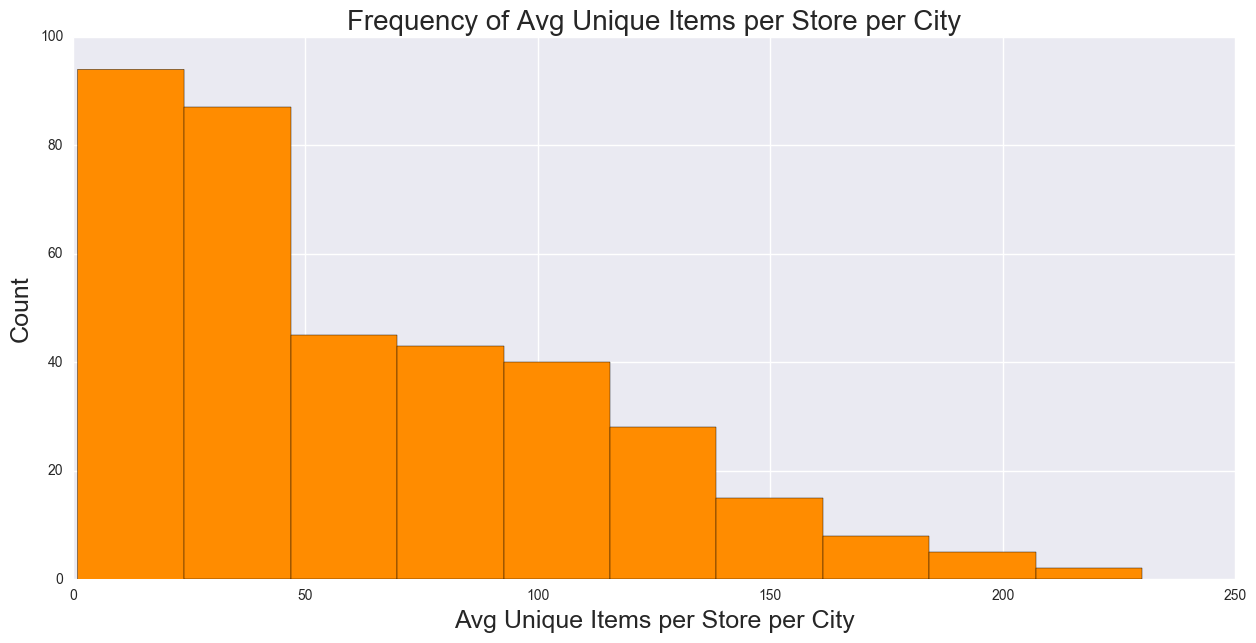

In [1002]:
#county_avgitems.hist(figsize = (15,7), color = 'darkorange')
#plt.title('Frequency of Avg Unique Items per Store per County',fontsize = 20)
#plt.xlabel('Avg Unique Items per Store per County',fontsize = 18)
#plt.ylabel('Count',fontsize = 18)


city_avgitems.hist(figsize = (15,7), color = 'darkorange')
plt.title('Frequency of Avg Unique Items per Store per City',fontsize = 20)
plt.xlabel('Avg Unique Items per Store per City',fontsize = 18)
plt.ylabel('Count',fontsize = 18);

Starting from the df (original) dataframe, and merging with various dataframes created prior, a dataframe is created to build metrics to be used as predictors for the regression, which are the following:
* Bottles Sold
* Items per Store
* Average Price
* Stores per City
* Population



In [1139]:
#Iowa population by City for 2015 from http://www.iowadatacenter.org/
city_pop_2015 = pd.read_csv('../Resources/IA_pop_2015.csv')
city_pop_2015.head()
city_pop_2015['City'] = city_pop_2015['City'].apply(lambda x: x.upper())

#using store number to build the dataframe to be used for regression
store_bottles_df = df[df['Bottles Sold'] < 26].groupby(['Store Number','City'])[['Bottles Sold','Sale (Dollars)']].sum()
store_bottles_df.reset_index(inplace = True)
# merging with unique items per store, which will be used as a predictor
store_bottles_uniq_df = pd.merge(store_bottles_df,unique_items_per_store)
#merging with total competitors per city, which will be used as a predictor
store_df = pd.merge(store_bottles_uniq_df,stores_per_city)
# creating a column for average price, which will be used as a predictor
store_df['AvgPrice'] = store_df['Sale (Dollars)'] / store_df['Bottles Sold']
#merging with city population for 2015, which will be used as a predictor

store_df = pd.merge(store_df,city_pop_2015,how='left')

#creating a groupby to find Bottles Sold and Sale (Dollars) by City and merging with main dataframe
city_sales = store_df.groupby('City')[['Bottles Sold','Sale (Dollars)']].sum()
city_sales.reset_index(inplace = True)
city_sales = city_sales.rename(columns = {'Bottles Sold':'Bottles_City','Sale (Dollars)':'Sales_City'})
store_df = pd.merge(store_df,city_sales)

#creating dataframes for target and the predictors

df_y = store_df.iloc[:,3]
df_X = store_df.iloc[:,[2,4,5,6, 7]]

# splitting into train and test

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.33)

Now that the data and target have been created, linear regression will be performed.

Linear Regression r^2 between Actual y and Predicted y_hat : 0.978638302957
The Predictors are: Bottles Sold,Unique_Items,Stores_per_City,AvgPrice,Population
Linear Regression Coefficients are: [  1.57166850e+01  -1.53576891e+01  -3.27081310e+00   5.33961116e+02
  -1.08477610e-02]
The r^2 on the test data is: 0.98273549983


,Store Number,City,Bottles Sold,Sale (Dollars),Unique_Items,Stores_per_City,AvgPrice,Population,Bottles_City,Sales_City,Delta,Sales/Store_per_City
0,2106,CEDAR FALLS,5393,81026.24,248,17,15.024335,41255,29003,399731.96,-124.486252,23513.644706
1,2572,CEDAR FALLS,5445,76956.87,739,17,14.133493,41255,29003,399731.96,3005.176534,23513.644706
2,2835,CEDAR FALLS,760,11303.42,73,17,14.872921,41255,29003,399731.96,361.349113,23513.644706
3,3769,CEDAR FALLS,3402,47338.44,139,17,13.914885,41255,29003,399731.96,-3601.951403,23513.644706
4,3995,CEDAR FALLS,2210,34036.77,98,17,15.401253,41255,29003,399731.96,407.339146,23513.644706
5,4119,CEDAR FALLS,424,7169.42,32,17,16.909009,41255,29003,399731.96,-208.702000,23513.644706
6,4147,CEDAR FALLS,1064,15156.59,94,17,14.244915,41255,29003,399731.96,94.488932,23513.644706
7,4590,CEDAR FALLS,284,2834.86,17,17,9.981901,41255,29003,399731.96,1125.514897,23513.644706
8,4631,CEDAR FALLS,355,3883.67,31,17,10.939915,41255,29003,399731.96,761.905638,23513.644706
9,4723,CEDAR FALLS,108,1405.32,8,17,13.012222,41255,29003,399731.96,705.818773,23513.644706


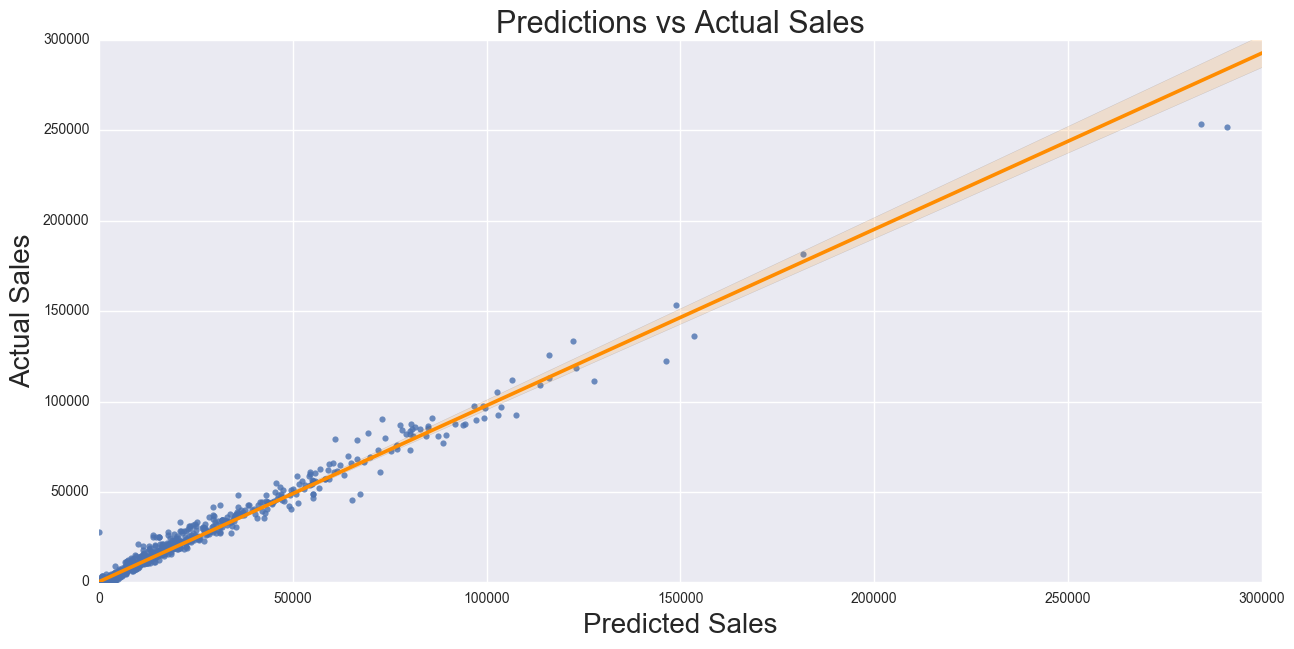

In [1140]:
#loading necessary methods
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.cross_validation import cross_val_predict,cross_val_score

#using linear regression
lr = linear_model.LinearRegression()

#fitting and predicting the model
lr_model = lr.fit(X_train,y_train)
lr_predict = lr.predict(X_train)
#computing the r-squared
lr_r2 =  r2_score(y_true=y_train, y_pred=lr_predict)
print 'Linear Regression r^2 between Actual y and Predicted y_hat :',lr_r2
print 'The Predictors are: {},{},{},{},{}'.format(df_X.columns[0],df_X.columns[1],df_X.columns[2],df_X.columns[3],df_X.columns[4])
print 'Linear Regression Coefficients are:',lr_model.coef_



test_linear_r2 =  r2_score(y_true=y_test, y_pred=lr.predict(X_test))
print 'The r^2 on the test data is:',test_linear_r2
#model fits on test data
df_y_predict = lr.predict(df_X)
plt.figure(figsize = (15,7))
sns.regplot(df_y,lr.predict(df_X),line_kws = {'color':'darkorange'})
plt.title('Predictions vs Actual Sales',fontsize = 22)
plt.xlabel('Predicted Sales',fontsize = 20)
plt.ylabel('Actual Sales',fontsize = 20)
plt.ylim(0,300000)
plt.xlim(0,300000)
#adding predictions to the main dataframe

delta = df_y - df_y_predict
store_df['Delta'] = pd.Series(delta)
store_df['Sales/Store_per_City'] = store_df['Sales_City'] / store_df['Stores_per_City']
store_df

The correlation on the training dataset is 0.98. The coefficients for the regression show the strongest predictor is Average Price (positively correlated), followed by Unique Items (negatively correlated), Bottles Sold (positively correlated), Stores per City/Number of competition (positively correlated), and then Population (negatively correlated).

What happens if another store enters the market? Using Bottles Sold / stores_per city, we can increase by one and find the new average of bottles sold / stores per city. Finding the ratio of new bottles/store over the old one, multiplied by bottles sold per store, we can find the number of bottles sold for each store assuming total demand for bottles sold per city and average price were constant. Using the new bottles sold, we can re-run the model to predict what the new Sales would be. From that we can find the highest Sales/stores per city average to figure out what cities to enter.

In [1110]:
store_zip = df.groupby(['Store Number','Zip Code'])['County'].nunique().to_frame()
store_zip.reset_index(inplace = True)
store_df = pd.merge(store_df,store_zip.iloc[:,0:2])
store_df.sort_values('Delta',ascending = False).head(10)
forecast = store_df.iloc[:,[0,1,12,2,3,4,5,6,7,8]].copy()
forecast.head(1)
#forecasting if one more store opened up. 
#Assuming bottles sold per city and price are constant, lets find a ratio to find forecasted bottles sold per city
forecast['Bottles/store'] = forecast['Bottles_City'] / forecast['Stores_per_City']
forecast['Bottles/(store+1)'] = (forecast['Bottles_City'] / (forecast['Stores_per_City'] + 1))
forecast['Bottles_marketshare'] = forecast['Bottles Sold'] / forecast['Bottles_City']
forecast['Bottles_forecast'] = (forecast['Bottles/(store+1)']*forecast['Stores_per_City']*forecast['Bottles_marketshare'])
forecast_X = forecast.iloc[:,[13,5,6,7,8]]
#using the model to predict sales when there is a new entry

forecast_sales = lr.predict(forecast_X)
forecast['Forecast_Sales_pred'] = pd.Series(forecast_sales)
forecast
#using calculated bottles forecast * average price

#forecast['Forecast_Sales_calc'] = forecast['Bottles_forecast'] * forecast['AvgPrice']

#analyzing which cities have the highest forecasted sales per store (with one additional entry)

forecast_city = forecast.groupby('City')[['Sale (Dollars)','Forecast_Sales_pred']].sum()
forecast_city.reset_index(inplace = True)

#merging with stores per city
forecast_city = pd.merge(forecast_city,stores_per_city)
forecast_city
#adding one to stores/city
forecast_city['Stores_w_entry'] = forecast_city['Stores_per_City'] + 1

#analyzing which cities have the highest forecasted sales/store
forecast_city['Sales/City'] = forecast_city['Sale (Dollars)'] / forecast_city['Stores_per_City']
forecast_city['Forecast_pred/entry'] = forecast_city['Forecast_Sales_pred'] / forecast_city['Stores_w_entry']
#forecast_city['Forecast_calc/entry'] = forecast_city['Forecast_Sales_calc'] / forecast_city['Stores_w_entry']

forecast_city.sort_values('Forecast_pred/entry',ascending = False).head()

,City,Sale (Dollars),Forecast_Sales_pred,Stores_per_City,Stores_w_entry,Sales/City,Forecast_pred/entry
168,IOWA CITY,603895.23,610385.747220,26,27,23226.739615,22606.879527
360,WINDSOR HEIGHTS,180010.82,144541.677351,6,7,30001.803333,20648.811050
30,BETTENDORF,311104.89,267861.374206,12,13,25925.407500,20604.721093
61,CLINTON,221324.28,222528.853874,10,11,22132.428000,20229.895807
233,MT VERNON,118258.16,78517.446356,3,4,39419.386667,19629.361589


Once we know which markets to enter, we can find the average number of items among the competitors,types of competitors, and also the items and prices to which we place in the store.

The Average Sales/City where there is at least 1 Liquor or Grocery Store: $ 76341.02


,Liquor,Grocery,Other,Sale (Dollars)
City,,,,
DES MOINES,11,33,46,1749891.08
CEDAR RAPIDS,13,21,40,1193081.11
DAVENPORT,10,12,20,781989.02
SIOUX CITY,3,11,20,612699.00
IOWA CITY,6,8,12,603895.23


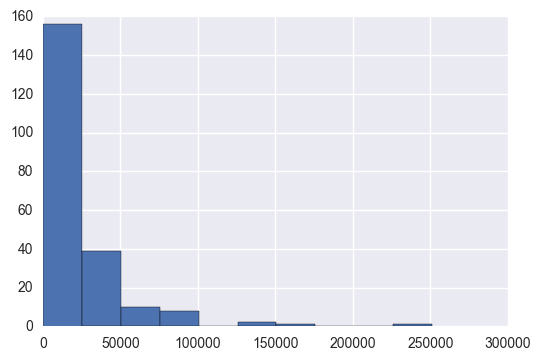

In [1098]:
#make all category names upper case
#create category bins to be used for portfolio
df['Category Name'] = df['Category Name'].apply(lambda x: str(x).upper())
category = df.groupby('Category Name')['Item Number'].nunique().to_frame()
category.reset_index(inplace = True)
#creating category bins 
cat_bins = []
for x in df['Category Name']:
    if 'VODKA' in x:
        cat_bins.append('VODKA')
    elif 'WHISKEY' in x:
        cat_bins.append('WHISKEY')
    elif 'RUM' in x:
        cat_bins.append('RUM')
    elif 'SCHNAPPS' in x:
        cat_bins.append('SCHNAPPS')
    elif 'BRANDIES' in x:
        cat_bins.append('BRANDIES')    
    elif 'GIN' in x:
        cat_bins.append('GIN') 
    elif 'SCOTCH' in x:
        cat_bins.append('SCOTCH') 
    elif 'BOURBON' in x:
        cat_bins.append('BOURBON')
    elif 'AMARETTO' in x:
        cat_bins.append('AMARETTO')         
    elif 'TEQUILA' in x:
        cat_bins.append('TEQUILA') 
    else:
        cat_bins.append('OTHER')
cat_bin_df = pd.DataFrame(cat_bins)
cat_bin_df = cat_bin_df.rename(columns = {0:'Category_Bins'})

#categorizing each store number
store_names = pd.read_csv('../Resources/IA_Data_Stores.csv')
city_store = train.groupby(['Store Number','City'])['County'].nunique().to_frame()
city_store.reset_index(inplace = True)
total_citystore = pd.merge(city_store,store_names,on='Store Number')
store_type = []
liquor_list = []
grocery_list = []
other_list = []
for x in total_citystore['Store Name']:
    if ('liquor' or 'spirits' or 'wine') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('spirits') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('wine') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('beverage') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('bottle') in x.lower():
        store_type.append('Liquor')  
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('vineyard') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('beer') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('cellar') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('holler') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('distribution') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('central city') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif ('distributing') in x.lower():
        store_type.append('Liquor')
        liquor_list.append(1)
        grocery_list.append(0)
        other_list.append(0)
    elif 'hy-vee' in x.lower():
        store_type.append('Grocery')
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'fareway' in x.lower():
        store_type.append('Grocery')
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'target'in x.lower():
        store_type.append('Grocery') 
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'wal-mart' in x.lower():
        store_type.append('Grocery') 
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'food' in x.lower():
        store_type.append('Grocery')
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'supermarket' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'dahl\'s' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)        
    elif 'sam\'s club' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)       
    elif 'econ-o-mart' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)          
    elif 'super valu' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'shop n save' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'grocery' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'pantry' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'costco' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'price chopper' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    elif 'save a lot' in x.lower():
        store_type.append('Grocery')           
        liquor_list.append(0)
        grocery_list.append(1)
        other_list.append(0)
    else:
        store_type.append('Other')
        liquor_list.append(0)
        grocery_list.append(0)
        other_list.append(1)
total_citystore['Store Type'] = pd.Series(store_type)
total_citystore['Liquor'] = pd.Series(liquor_list)
total_citystore['Grocery'] = pd.Series(grocery_list)
total_citystore['Other'] = pd.Series(other_list)

total_citystore_merge = total_citystore.iloc[:,[0,1,3,4,5,6,7]]
 
#groupby store type and evaluate metrics for each store type for the state of iowa
#liquor stores have higher mean liquor sales than groceries and convenience stores
#convenience stores might be the go to place for small rural towns
store_type_sales.groupby('Store Type')['Sale (Dollars)'].agg({sum,len,np.mean})

#what about cities where there are at least one liquor store or grocery stores
city_type_sales = store_type_sales.groupby('City')[['Liquor','Grocery','Other','Sale (Dollars)']].sum()
#the average sales per city where there is at least 1 grocery or 1 liquor store
mean_city_grocery_liquor = city_type_sales[(city_type_sales['Liquor']>0) |(city_type_sales['Grocery']>0)]['Sale (Dollars)'].mean()
print 'The Average Sales/City where there is at least 1 Liquor or Grocery Store: $',mean_city_grocery_liquor.round(2)
city_type_sales.sort_values('Sale (Dollars)',ascending = False).head()

## Record your findings

The skewed variables are:

Avg_items_store is the average items per store for the county, it is a proxy for size of store

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.